## Import Modules

In [1]:
import pandas as pd
import numpy as np
import os, random, codecs, json, pickle
seed = 99
random.seed(seed)
np.random.seed(seed)
from collections import Counter

from ast import literal_eval
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import gensim.test.utils 
import bitermplus
import tqdm
import itertools

%matplotlib inline
import matplotlib.pyplot as plt
from pyvis.network import Network

import tomotopy as tp
from tomotopy.utils import Corpus
import tmplot as tmp
import altair
import ipywidgets

from imp import reload
import pyLDAvis
import pyLDAvis.gensim_models
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
print(tp.isa)

avx2


## Data Cleaning

In [2]:
#read the dataframe
df = pd.read_csv('data/lavrovall22.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5213 entries, 0 to 5212
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   mfa_titlesall  5213 non-null   object 
 1   mfa_datesall   5213 non-null   object 
 2   mfa_linksall   5213 non-null   object 
 3   lavrovcontent  0 non-null      float64
 4   content        5208 non-null   object 
 5   doc_id         5213 non-null   object 
 6   ruskymir       5213 non-null   int64  
 7   Date           5213 non-null   object 
 8   Year           5213 non-null   int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 366.7+ KB


In [3]:
#trasnform date into datetime
df['date'] = pd.to_datetime(df.Date)
df['date'].sort_values()

4373   2004-03-18
4149   2004-03-22
2152   2004-03-24
5018   2004-03-27
1696   2004-04-01
          ...    
844    2022-12-07
845    2022-12-07
3585   2022-12-10
1049   2022-12-12
1052   2022-12-14
Name: date, Length: 5213, dtype: datetime64[ns]

In [4]:
#rename col
df.rename(columns = {'mfa_linksall':'url', 'mfa_titlesall': 'title', 'content':'text'}, inplace = True)

In [5]:
#create new df and insert col 'speaker'
lavrov = df[['date','url', 'title', 'text' ]]
lavrov.insert(0, 'speaker', 'С.Лавров')
lavrov.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5213 entries, 0 to 5212
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   speaker  5213 non-null   object        
 1   date     5213 non-null   datetime64[ns]
 2   url      5213 non-null   object        
 3   title    5213 non-null   object        
 4   text     5208 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 203.8+ KB


In [6]:
#check for the null text col
# either they are video or pic. no text to scrape. therefore, they will be dropped
#pd.set_option('display.max_colwidth', 200)
lavrov = lavrov[lavrov['text'].notna()]
lavrov.info()
#save it as pickle
lavrov.to_pickle('data/lavrov_5_col.pkl')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5208 entries, 0 to 5212
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   speaker  5208 non-null   object        
 1   date     5208 non-null   datetime64[ns]
 2   url      5208 non-null   object        
 3   title    5208 non-null   object        
 4   text     5208 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 244.1+ KB


## Text Cleaning

In [7]:
#read the dataframe
lavrov = pd.read_pickle('data/lavrov_5_col.pkl')
# how many words are articles made of
lavrov['word_count'] = lavrov['text'].str.split().str.len()
lavrov['word_count'].sort_values(ascending=False)

4257    16461
1516    13620
1085    13291
1229    12260
1312    12003
        ...  
2761       15
5137       15
3554       14
4142        5
5140        0
Name: word_count, Length: 5208, dtype: int64

In [8]:
#Identify Noise with Regular Expression
import re 
RE_SUSPICIOUS = re.compile(r'[\xa0Äô&#<>{}\[\]\\]')

def impurity(text, min_len=10): 
    """returns the share of suspicious characters in a text""" 
    if text == None or len(text) < min_len: 
        return 0 
    else: 
        return len(RE_SUSPICIOUS.findall(text))/len(text)

In [9]:
# add new column to data frame
lavrov['impurity'] = lavrov['text'].apply(impurity, min_len=10)
lavrov['impurity'].sort_values().value_counts()

0.000000    2377
0.001193       4
0.002611       4
0.001175       3
0.000562       3
            ... 
0.000428       1
0.000428       1
0.000429       1
0.000430       1
0.070064       1
Name: impurity, Length: 2677, dtype: int64

In [10]:
# get the top 3 records 
#critical part is just []...I will leave as it is for the moment
pd.set_option('display.max_colwidth', 200)
lavrov[['text', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

,text,impurity
3699,"Абу-Даби, 1-2 февраля 2016 года Рабочий визит Министра иностранных дел России С.В.Лаврова в Объединенные Арабские Эмираты СТРАНА ФОТО ВИДЕО СОЦСЕТИ",0.070064
4003,"УКАЗ ПРЕЗИДЕНТА РОССИЙСКОЙ ФЕДЕРАЦИИ Назначить Мешкова Алексея Юрьевича заместителем Министра иностранных дел Российской Федерации. Президент Российской Федерации В.Путин Москва, Крем...",0.025547
2065,"С.В.Лавров: Уважаемый Владимир Владимирович! Уважаемые коллеги! Как я докладывал Президенту неделю назад, мы подготовили оценку тех предложений по гарантиям безопасности, о которых Россия выдвинул...",0.023196


In [11]:
#create a function to clean the text
def clean(text):
     # everything non-alpahnumeric with a space
     text = re.sub(r'\W+',' ', text)
     # Two or more dots with space
     text = re.sub(r'\.{2,}', ' ', text)
     # convert text to lowercase             
     text = text.lower()
     # match all digits
     text = re.sub(r'\d+',' ', text)
     # sequences of white spaces
     text = re.sub(r'\s+', ' ', text)
     #\xa0
     text = re.sub(r'[\xa0]', ' ', text)
     return text.strip()

In [12]:
#apply the function
lavrov['text'] = lavrov['text'].map(clean)

In [13]:
# get the top 3 records 
#critical part is just []...I will leave as it is for the moment
lavrov[['text', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

,text,impurity
3699,абу даби февраля года рабочий визит министра иностранных дел россии с в лаврова в объединенные арабские эмираты страна фото видео соцсети,0.070064
4003,указ президента российской федерации назначить мешкова алексея юрьевича заместителем министра иностранных дел российской федерации президент российской федерации в путин москва кремль декабря года...,0.025547
2065,с в лавров уважаемый владимир владимирович уважаемые коллеги как я докладывал президенту неделю назад мы подготовили оценку тех предложений по гарантиям безопасности о которых россия выдвинула соо...,0.023196


In [14]:
lavrov.drop(columns=['impurity'], inplace=True)

In [15]:
#save it as pickle
lavrov.to_pickle('data/lavrov_clean.pkl')

## Text Processing

In [41]:
lavrov = pd.read_pickle('data/lavrov_clean.pkl')
lavrov['word_count'] = lavrov['text'].str.split().str.len()
lavrov['word_count'].sort_values(ascending=False)
lavrov.reset_index(drop=True)

,speaker,date,url,title,text,word_count
0,С.Лавров,2016-12-02,http://mid.ru/ru/press_service/minister_speeches/1538972/,"Выступление и ответы на вопросы Министра иностранных дел России С.В.Лаврова на второй международной конференции «Средиземноморье: римский диалог», Рим, 2 декабря 2016 года",я наверное не буду выступать с речью мне кажется будет более продуктивно если мы с вами побеседуем в интерактивном режиме я хотел бы поблагодарить организаторов конференции министерство иностранны...,3663
1,С.Лавров,2016-06-16,http://mid.ru/ru/press_service/minister_speeches/1530316/,Выступление и ответы на вопросы Министра иностранных дел России С.В.Лаврова на сессии Международного дискуссионного клуба «Валдай» «Россия и ЕС: что после «стратегического партнерства»...,я хотел бы поблагодарить клуб валдай за внимание к актуальным проблемам мировой политики думаю что авторитетная аудитория которая здесь собирается как и на предыдущих мероприятиях валдайского клуб...,3331
2,С.Лавров,2016-02-29,http://mid.ru/ru/press_service/minister_speeches/1523517/,"Заявление для СМИ Министра иностранных дел России С.В.Лаврова по итогам переговоров с Президентом Алжира А.Бутефликой, Алжир, 29 февраля 2016 года",я хотел бы выразить искреннюю признательность президенту алжира а бутефлике всем членам алжирского руководства за великолепный прием гостеприимство и за очень содержательные переговоры главный ито...,510
3,С.Лавров,2016-05-03,http://mid.ru/ru/press_service/minister_speeches/1527820/,Комментарий Министра иностранных дел России С.В.Лаврова для СМИ в связи с отмечаемым 3 мая Всемирным днем свободы печати,я хотел бы воспользоваться возможностью и поздравить журналистское сообщество с профессиональным праздником как известно сегодня всемирный день свободы печати который был провозглашен генеральной ...,225
4,С.Лавров,2006-04-07,http://mid.ru/ru/press_service/minister_speeches/1701288/,"Стенограмма выступления Министра иностранных дел России С.В.Лаврова на церемонии награждения граждан ФРГ орденами Дружбы, Берлин, 6 апреля 2006 года",я рад выполнить важную и почетную миссию которую на меня возложил президент россии в в путин и вручить нашим немецким друзьям высокие награды россии ордена дружбы уважаемый господин мангольд уважа...,309
...,...,...,...,...,...,...
5203,С.Лавров,2011-11-29,http://mid.ru/ru/press_service/minister_speeches/1632683/,"Выступление и ответы Министра иностранных дел России С.В.Лаврова на вопросы СМИ в ходе пресс-конференции по итогам переговоров с Министром иностранных дел Исландии Э.Скарпхьединссоном, М...",уважаемые дамы и господа в ходе переговоров с моим исландским коллегой мы констатировали поступательное и продуктивное развитие двусторонних отношений активизируется политический диалог на всех ур...,1112
5204,С.Лавров,2011-11-29,http://mid.ru/ru/press_service/minister_speeches/1740724/,"Письменное интервью Министра иностранных дел России С.В.Лаврова корреспонденту «Темпо» по итогам участия в Восточноазиатском саммите, о.Бали, Индонезия, 18-19 ноября 2011 года",участие в восточноазиатском саммите вас на высшем уровне который состоялся ноября г в районе нуса дуа о бали российская федерация приняла впервые идея о создании вас была выдвинута в г в куала лум...,684
5205,С.Лавров,2010-09-22,http://mid.ru/ru/press_service/minister_speeches/1729474/,"Совместная статья Министра иностранных дел России С.В.Лаврова и Министра иностранных дел Норвегии И.Г.Стере «Управляя Арктикой», «Globe and Mail», 21 сентября 2010 года",часто можно услышать что на земле осталось мало поистине нетронутых мест но продуваемые ветрами просторы арктики несомненно относятся к таковым некоторые политические аналитики даже утверждают что...,688
5206,С.Лавров,2010-09-22,http://mid.ru/ru/press_service/minister_speeches/1600471/,"Выступление Министра иностранных дел России С.В.Лаврова на Пленарном заседании высокого уровня 65-й сессии Генассамблеи ООН по Целям развития тысячелетия, Нью-Йорк, 21 сентября 2010 года...",уважаемый господин председатель дамы и господа ро

In [17]:
import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.ru.stop_words import STOP_WORDS
#run the first model with no customised stopwords to see what are the most common (useless) words

In [18]:
nlp_spacy = spacy.load('ru_core_news_sm', exclude=["ner"])
nlp_spacy.disable_pipe("parser")
nlp_spacy.enable_pipe("senter")

In [42]:
lemma = []
#Turn words into lemmas
for doc in nlp_spacy.pipe(lavrov['text'].astype('unicode').values, batch_size=50):
    lemma.append([n.lemma_ for n in doc
                if n.lemma_ not in STOP_WORDS])

lavrov['lemma'] = lemma

In [50]:
lavrov.to_pickle('data/lavrov_clean.pkl')

In [51]:
read_lemma = pd.read_pickle('data/lavrov_clean.pkl')

In [52]:
lavrov = read_lemma[['date','url', 'speaker', 'title', 'text','lemma']].reset_index(drop=True)
lavrov.head()

,date,url,speaker,title,text,lemma
0,2016-12-02,http://mid.ru/ru/press_service/minister_speeches/1538972/,С.Лавров,"Выступление и ответы на вопросы Министра иностранных дел России С.В.Лаврова на второй международной конференции «Средиземноморье: римский диалог», Рим, 2 декабря 2016 года",я наверное не буду выступать с речью мне кажется будет более продуктивно если мы с вами побеседуем в интерактивном режиме я хотел бы поблагодарить организаторов конференции министерство иностранны...,"[наверное, выступать, речь, продуктивный, побеседуем, интерактивный, режим, поблагодарить, организатор, конференция, министерство, иностранный, дело, италия, институт, внешнеполитический, исследов..."
1,2016-06-16,http://mid.ru/ru/press_service/minister_speeches/1530316/,С.Лавров,Выступление и ответы на вопросы Министра иностранных дел России С.В.Лаврова на сессии Международного дискуссионного клуба «Валдай» «Россия и ЕС: что после «стратегического партнерства»...,я хотел бы поблагодарить клуб валдай за внимание к актуальным проблемам мировой политики думаю что авторитетная аудитория которая здесь собирается как и на предыдущих мероприятиях валдайского клуб...,"[поблагодарить, клуб, валдай, внимание, актуальный, проблема, мировой, политика, думать, авторитетный, аудитория, собираться, предыдущий, мероприятие, валдайский, клуб, весьма, заинтересована, иск..."
2,2016-02-29,http://mid.ru/ru/press_service/minister_speeches/1523517/,С.Лавров,"Заявление для СМИ Министра иностранных дел России С.В.Лаврова по итогам переговоров с Президентом Алжира А.Бутефликой, Алжир, 29 февраля 2016 года",я хотел бы выразить искреннюю признательность президенту алжира а бутефлике всем членам алжирского руководства за великолепный прием гостеприимство и за очень содержательные переговоры главный ито...,"[выразить, искренний, признательность, президент, алжир, бутефлике, член, алжирский, руководство, великолепный, приём, гостеприимство, содержательный, переговоры, главный, итог, чёткий, подтвержде..."
3,2016-05-03,http://mid.ru/ru/press_service/minister_speeches/1527820/,С.Лавров,Комментарий Министра иностранных дел России С.В.Лаврова для СМИ в связи с отмечаемым 3 мая Всемирным днем свободы печати,я хотел бы воспользоваться возможностью и поздравить журналистское сообщество с профессиональным праздником как известно сегодня всемирный день свободы печати который был провозглашен генеральной ...,"[воспользоваться, возможность, поздравить, журналистский, сообщество, профессиональный, праздник, известный, сегодня, всемирный, день, свобода, печать, провозгласить, генеральный, ассамблея, оон, ..."
4,2006-04-07,http://mid.ru/ru/press_service/minister_speeches/1701288/,С.Лавров,"Стенограмма выступления Министра иностранных дел России С.В.Лаврова на церемонии награждения граждан ФРГ орденами Дружбы, Берлин, 6 апреля 2006 года",я рад выполнить важную и почетную миссию которую на меня возложил президент россии в в путин и вручить нашим немецким друзьям высокие награды россии ордена дружбы уважаемый господин мангольд уважа...,"[рад, выполнить, важный, почётный, миссия, возложить, президент, россия, путин, вручить, немецкий, друг, высокий, награда, россия, орден, дружба, уважаемый, господин, мангольд, уважаемый, господин..."
...,...,...,...,...,...,...
5203,2011-11-29,http://mid.ru/ru/press_service/minister_speeches/1632683/,С.Лавров,"Выступление и ответы Министра иностранных дел России С.В.Лаврова на вопросы СМИ в ходе пресс-конференции по итогам переговоров с Министром иностранных дел Исландии Э.Скарпхьединссоном, М...",уважаемые дамы и господа в ходе переговоров с моим исландским коллегой мы констатировали поступательное и продуктивное развитие двусторонних отношений активизируется политический диалог на всех ур...,"[уважаемые, дама, господин, ход, переговоров, исландский, коллега, констатировать, поступательный, продуктивный, развитие, двусторонний, отношение, активизироваться, политический, диалог, уровень,..."
5204,2011-11-29,http://mid.ru/ru/press_service/minister_speeches/17

## Read the lemma

In [53]:
data_lemma = lavrov['lemma'].tolist()
docs = data_lemma

In [54]:
# Add bigrams
from gensim.models.phrases import Phrases
# Add bigrams to docs (only ones that appear several times or more).
bigram = Phrases(docs, min_count=100)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [61]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
dictionary = Dictionary(docs)
#dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]
#MmCorpus.serialize("models/corpus.mm", corpus)

print('Number of unique tokens: %d' % len(dictionary))
print('Number of docs: %d (%d)' % (len(corpus),len(docs)))

Number of unique tokens: 55510
Number of docs: 5208 (5208)


In [62]:
from collections import Counter
c = Counter()
for d in docs:
    c.update(d)

# 10 least common words in the corpus, by frequency
c.most_common()[-10:]

[('темпо', 1),
 ('рита', 1),
 ('продувать', 1),
 ('суров', 1),
 ('сфокусированном', 1),
 ('илулиссатскую', 1),
 ('наполненного', 1),
 ('выносимый', 1),
 ('ураганы', 1),
 ('прикаспия', 1)]

In [63]:
min_wordcount = 10

c = Counter()
for d in docs:
    c.update(d)

# 10 most common words in the corpus, by frequency
c.most_common(min_wordcount)

[('россия', 38639),
 ('вопрос', 32080),
 ('страна', 28163),
 ('год', 19406),
 ('российский', 19191),
 ('международный', 18677),
 ('отношение', 17470),
 ('оон', 15734),
 ('безопасность', 14699),
 ('президент', 14456)]

In [65]:
from itertools import chain
c = Counter(chain.from_iterable(docs))
word = 'мир'
print("The word '{}' appears {} times in the list of lists.".format(word, c[word]))

The word 'мир' appears 8250 times in the list of lists.


## Correlated Topic Model 10 Topics

In [72]:
import tomotopy as tp

# CTM model with 15 topics, removal of words appearing in fewer than 0.5% of the documents, 
# minimum word count. no words removal
params = {'num_topics': 10, 'min_cf': 100, 'min_df': int(len(docs)*0.005), 'random_state': seed}

In [73]:
ctm = tp.CTModel(k=params['num_topics'],min_cf=params['min_cf'],min_df=params['min_df'],
        seed=params['random_state'])

In [74]:
# Since we have more than ten thousand of documents, 
# setting the `num_beta_sample` smaller value will not cause an inaccurate result.
ctm.num_beta_sample = 5

In [75]:
for doc in docs:
    ctm.add_doc(doc)

for i in range(0, 1001, 100):
    ctm.train(10)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, ctm.ll_per_word))

/var/folders/mm/gw92vpys6rggjz_4z42s244w0000gn/T/ipykernel_1067/3222773177.py:5: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  ctm.train(10)


Iteration: 0	Log-likelihood: -7.354478096829603
Iteration: 100	Log-likelihood: -7.196770625229124
Iteration: 200	Log-likelihood: -7.082271688099295
Iteration: 300	Log-likelihood: -6.982632517797856
Iteration: 400	Log-likelihood: -6.9066611225329675
Iteration: 500	Log-likelihood: -6.83341082587338
Iteration: 600	Log-likelihood: -6.766894791513803
Iteration: 700	Log-likelihood: -6.7190660381114995
Iteration: 800	Log-likelihood: -6.662018394390371
Iteration: 900	Log-likelihood: -6.624780811195937
Iteration: 1000	Log-likelihood: -6.58383030893352


In [76]:
print('Num docs:{}, Num Vocabs:{}, Total Words:{}'.format(
    len(ctm.docs), len(ctm.used_vocabs), ctm.num_words
))

Num docs:5207, Num Vocabs:4351, Total Words:3230540


In [77]:
for k in range(ctm.k):
        print('Topic #{}'.format(k))
        for word, prob in ctm.get_topic_words(k):
            print('\t', word, prob, sep='\t')

Topic #0
		международный	0.011544193141162395
		сторона	0.010617582127451897
		год	0.010423639789223671
		россия	0.009891069494187832
		российский	0.00963863730430603
		страна	0.009102988056838512
		работа	0.008330298587679863
		вопрос	0.008213317953050137
		иностранный	0.008170219138264656
		безопасность	0.008087101392447948
Topic #1
		россия	0.011579825542867184
		вопрос	0.00932238157838583
		страна	0.009297744370996952
		российский	0.006975625641644001
		ситуация	0.006104060914367437
		сделать	0.005543549545109272
		программа	0.0055158319883048534
		партнёр	0.005315649323165417
		время	0.005284852348268032
		сотрудничество	0.005214018281549215
Topic #2
		россия	0.012122784741222858
		страна	0.008753112517297268
		безопасность	0.008095312863588333
		вопрос	0.007242034655064344
		сотрудничество	0.006351522635668516
		отношение	0.006208792328834534
		конфликт	0.006087782327085733
		сша	0.006022622808814049
		сегодня	0.005929538048803806
		усилие	0.005901612341403961
Topic #3
		страна	0

In [78]:
# calculate coherence using preset
for preset in ('u_mass', 'c_uci', 'c_npmi', 'c_v'):
    coh = tp.coherence.Coherence(ctm, coherence=preset)
    average_coherence = coh.get_score()
    coherence_per_topic = [coh.get_score(topic_id=k) for k in range(ctm.k)]
    print('==== Coherence : {} ===='.format(preset))
    print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
    print()

==== Coherence : u_mass ====
Average: -0.362618139304552 
Per Topic: [-0.2856128675944611, -0.4609432696792794, -0.45757717689837296, -0.38803364575611715, -0.3521694624729206, -0.28603919751976925, -0.346362398882663, -0.33997092385985905, -0.38526145054940186, -0.32421099983267565]

==== Coherence : c_uci ====
Average: -0.11534007183990487 
Per Topic: [-0.18491019401270045, -0.10788111549054405, -0.1294106178599122, 0.03735323330799882, -0.07741695022669616, -0.08874604831519729, -0.15490579533348617, -0.11670152497880155, -0.18342231040979506, -0.14735939507991455]

==== Coherence : c_npmi ====
Average: -0.012376251541718508 
Per Topic: [-0.025738089958595504, -0.01342606760790124, -0.01255128897785024, 0.010871484530408601, -0.006994438235001494, -0.009584440405416969, -0.016014504982147366, -0.008787702403259342, -0.02536094460587053, -0.016176522771551006]

==== Coherence : c_v ====
Average: 0.36338541269302366 
Per Topic: [0.3534984543919563, 0.3568205922842026, 0.36031837314367

In [79]:
# topic correlations

topics_correlations = np.zeros((ctm.k,ctm.k))

for k in range(ctm.k):
    for m,c in enumerate(ctm.get_correlations(k)):
        topics_correlations[k][m] = c

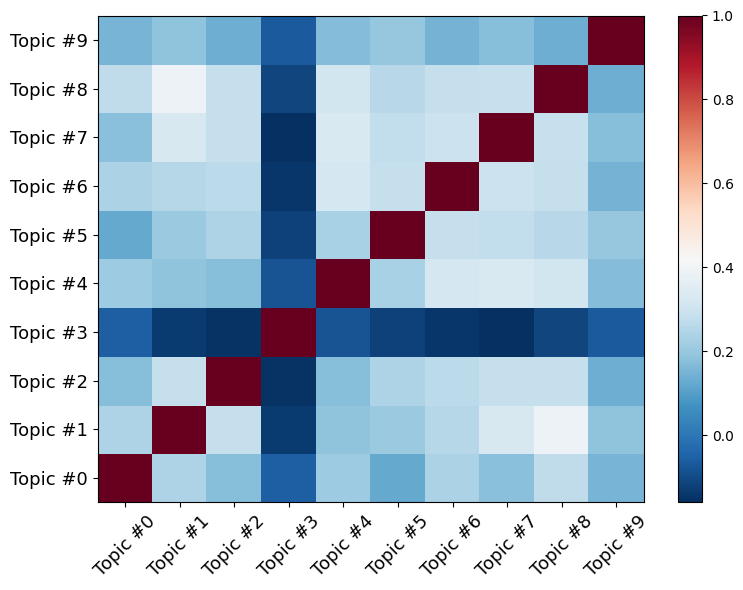

In [80]:
fig = plt.figure(figsize=(8, 6))
plt.pcolor(topics_correlations, norm=None, cmap='RdBu_r')
plt.yticks(np.arange(ctm.k)+0.5, ["Topic #"+str(n) for n in range(ctm.k)])
plt.xticks(np.arange(ctm.k)+0.5, ["Topic #"+str(n) for n in range(ctm.k)], rotation = 45)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.tick_params(labelsize=13)
plt.tight_layout()  # fixes margins

## LDA 10 topics

In [81]:
import tomotopy as tp

# LDA model with 10 topics, removal of words appearing in fewer than 0.5% of the documents, 
# minimum word count
params = {'num_topics': 10, 'min_cf': 100, 'min_df': int(len(docs)*0.005), 'random_state': seed, 'dic': Dictionary}

In [83]:
lda = tp.LDAModel(k=params['num_topics'],min_cf=params['min_cf'],min_df=params['min_df'],seed=params['random_state'])

In [84]:
for doc in docs:
    lda.add_doc(doc)

for i in range(0, 1000, 10):
    lda.train(10)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, lda.ll_per_word))

/var/folders/mm/gw92vpys6rggjz_4z42s244w0000gn/T/ipykernel_1067/4240426511.py:5: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  lda.train(10)


Iteration: 0	Log-likelihood: -9.121350692619652
Iteration: 10	Log-likelihood: -8.529095284674526
Iteration: 20	Log-likelihood: -8.392816024080934
Iteration: 30	Log-likelihood: -8.340785024686355
Iteration: 40	Log-likelihood: -8.312389229848232
Iteration: 50	Log-likelihood: -8.297399017797401
Iteration: 60	Log-likelihood: -8.28697582717531
Iteration: 70	Log-likelihood: -8.279933149423886
Iteration: 80	Log-likelihood: -8.272276840163386
Iteration: 90	Log-likelihood: -8.269748044657794
Iteration: 100	Log-likelihood: -8.263952995016828
Iteration: 110	Log-likelihood: -8.259553129649658
Iteration: 120	Log-likelihood: -8.25758149196184
Iteration: 130	Log-likelihood: -8.253268596631308
Iteration: 140	Log-likelihood: -8.251103833837808
Iteration: 150	Log-likelihood: -8.250125869255275
Iteration: 160	Log-likelihood: -8.248920881425853
Iteration: 170	Log-likelihood: -8.24857020177823
Iteration: 180	Log-likelihood: -8.247311199700501
Iteration: 190	Log-likelihood: -8.245792442980255
Iteration: 200

In [85]:
for k in range(lda.k):
        print('Topic #{}'.format(k))
        for word, prob in lda.get_topic_words(k):
            print('\t', word, prob, sep='\t')

Topic #0
		россия	0.02066599577665329
		экономический	0.016102680936455727
		сотрудничество	0.015832889825105667
		страна	0.015455183573067188
		регион	0.013127276673913002
		российский	0.011732074432075024
		развитие	0.010941972956061363
		год	0.010726140812039375
		проект	0.008868440054357052
		область	0.006829594261944294
Topic #1
		российский	0.019525494426488876
		год	0.013201966881752014
		россия	0.01298671867698431
		работа	0.009102675132453442
		международный	0.00816036481410265
		страна	0.008083831518888474
		федерация	0.007873366586863995
		русский	0.007543318439275026
		народ	0.00675885658711195
		российский_федерация	0.006720589939504862
Topic #2
		вопрос	0.018981996923685074
		страна	0.013026159256696701
		россия	0.012437774799764156
		лавр	0.012081975117325783
		говорить	0.011644493788480759
		сша	0.011201474815607071
		сказать	0.008582123555243015
		президент	0.007534106727689505
		отношение	0.006263196002691984
		человек	0.006256273947656155
Topic #3
		украина	0.0342433

In [89]:
topic_term_dists = np.stack([lda.get_topic_word_dist(k) for k in range(lda.k)])
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in lda.docs])
doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
doc_lengths = np.array([len(doc.words) for doc in lda.docs])
counter = Counter(doc_lengths)
vocab = list(lda.used_vocabs)
term_frequency = lda.used_vocab_freq

In [92]:
pyLDAvis.enable_notebook()
from imp import reload

In [93]:
prepared_data = pyLDAvis.prepare(
    topic_term_dists, 
    doc_topic_dists, 
    doc_lengths, 
    vocab, 
    term_frequency,
    start_index=0, # tomotopy starts topic ids with 0, pyLDAvis with 1
    sort_topics=False # IMPORTANT: otherwise the topic_ids between pyLDAvis and tomotopy are not matching!
)

In [94]:
prepared_data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.148345 -0.136785       0        1   7.997022
1     -0.217290  0.067425       1        1   6.607859
2      0.004964  0.245018       2        1  22.667702
3      0.182162 -0.038791       3        1   6.395910
4     -0.048684  0.075503       4        1  12.393839
5      0.114482 -0.082356       5        1   7.511172
6     -0.045827 -0.127512       6        1   7.665506
7      0.097266  0.043210       7        1  10.255224
8      0.195939 -0.008737       8        1   6.750979
9     -0.134668 -0.036974       9        1  11.754787, topic_info=             Term          Freq         Total Category  logprob  loglift
43        украина   8363.000000   8363.000000  Default  30.0000  30.0000
55          сирия   7175.000000   7175.000000  Default  29.0000  29.0000
7             оон  17412.000000  17412.000000  Default  28.0000  28.0000
92      сирийский   5376.000000   5376.000000  Default  27.0000  27.0000
1          вопрос  35690.000000  35690.000000  Default  26.0000  26.0000
..            ...           ...           ...      ...      ...      ...
1          вопрос   4414.496810  35690.352944   Topic9  -4.5617   0.0509
5   международный   3303.969103  20770.858516   Topic9  -4.8515   0.3025
22  экономический   2532.677257  10684.547399   Topic9  -5.1174   0.7014
2          страна   3173.578924  31410.922008   Topic9  -4.8918  -0.1514
44         диалог   2077.416238   8207.496768   Topic9  -5.3155   0.7670

[773 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
4302      7  1.000365               mid
3070      7  0.998589     press_service
2710      1  0.055482                ru
2710      7  0.947462                ru
1405      0  0.001883               the
...     ...       ...               ...
531       2  0.036702            япония
4070      0  0.997204        япония_абэ
981       0  0.999435          японский
3524      0  0.989352  японский_коллега
3524      6  0.006262  японский_коллега

[2011 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [95]:
# calculate coherence using preset
for preset in ('u_mass', 'c_uci', 'c_npmi', 'c_v'):
    coh = tp.coherence.Coherence(lda, coherence=preset)
    average_coherence = coh.get_score()
    coherence_per_topic = [coh.get_score(topic_id=k) for k in range(lda.k)]
    print('==== Coherence : {} ===='.format(preset))
    print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
    print()

==== Coherence : u_mass ====
Average: -0.44233820548647246 
Per Topic: [-0.3911160242423594, -0.5894836564403059, -0.446402432882505, -0.6048333800186003, -0.4784659610955039, -0.44957887368238914, -0.34513071544487284, -0.5448149339037879, -0.33815464172607546, -0.2354014354283249]

==== Coherence : c_uci ====
Average: 0.1571158263320058 
Per Topic: [0.22998014547453136, -0.5518486777606058, 0.1876097246614318, 0.38364253938929244, 0.19890742600024838, 0.17240251835399414, 0.23300880786553108, 0.08807643949051652, 0.515203271566518, 0.11417606827860016]

==== Coherence : c_npmi ====
Average: 0.030561998874859907 
Per Topic: [0.037574371332075675, -0.04917585790800208, 0.035677340271087515, 0.05969621650910736, 0.031911359638281254, 0.03475907205279662, 0.03901274926529163, 0.017273848800755158, 0.07383354864604516, 0.025057340141160803]

==== Coherence : c_v ====
Average: 0.503747376872925 
Per Topic: [0.5830549776554108, 0.3966351978364401, 0.46083874553442, 0.5669810459017753, 0.522

In [99]:
#theta(topics vs documents probability) matrices
tmp.get_theta(lda)
# I need something similar to calculate topics vs documents LENGTH probability

docs,0,1,2,3,4,5,6,7,8,9,...,5197,5198,5199,5200,5201,5202,5203,5204,5205,5206
topics,,,,,,,,,,,,,,,,,,,,,
0,0.003529,0.036374,0.000642,0.001706,0.079625,0.010042,0.003710,0.176195,0.083369,0.004668,...,0.084609,0.040762,0.000215,0.000199,0.118814,0.134103,0.717775,0.076200,0.266252,0.127970
1,0.014325,0.000146,0.000724,0.434020,0.443723,0.495468,0.004185,0.001121,0.002035,0.008599,...,0.001270,0.445925,0.003156,0.022776,0.079421,0.006048,0.013224,0.015757,0.010571,0.135783
2,0.489294,0.459739,0.073797,0.103630,0.030406,0.299590,0.141449,0.001934,0.019824,0.177486,...,0.097022,0.059003,0.201467,0.350379,0.056957,0.154327,0.007259,0.001085,0.049195,0.005510
3,0.124880,0.174859,0.000329,0.000875,0.045427,0.000932,0.001902,0.000509,0.000925,0.011901,...,0.000115,0.000128,0.000110,0.012731,0.000235,0.000161,0.000240,0.000286,0.000228,0.004289
4,0.016053,0.062139,0.009560,0.287764,0.001649,0.002422,0.004942,0.190002,0.043185,0.184611,...,0.017583,0.095987,0.222702,0.065212,0.037987,0.000419,0.102189,0.439471,0.292578,0.162921
5,0.026216,0.000122,0.424284,0.055623,0.001169,0.001717,0.003504,0.027892,0.776574,0.000798,...,0.355031,0.000235,0.105098,0.049800,0.316048,0.111313,0.000442,0.000527,0.115201,0.000804
6,0.000144,0.000148,0.029755,0.086831,0.001419,0.002084,0.004252,0.005631,0.018380,0.291487,...,0.001274,0.271498,0.000246,0.195069,0.311987,0.246589,0.049203,0.366246,0.252221,0.416999
7,0.000119,0.000122,0.000607,0.001613,0.001171,0.034614,0.037065,0.234541,0.001706,0.157527,...,0.025629,0.019367,0.314888,0.200441,0.066879,0.088541,0.066037,0.091299,0.006462,0.008510
8,0.294513,0.177779,0.142512,0.000847,0.000615,0.009126,0.354184,0.000493,0.000895,0.000420,...,0.163796,0.001249,0.104030,0.040691,0.000228,0.075590,0.008696,0.000277,0.000221,0.000423


In [100]:
#get documents with maximum probabilities 𝑃(𝑡|𝑑) for each topic:
tmp.get_top_docs(docs, model=lda)

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,"[уважаемые, дама, господин, дорогой, друг, поблагодарить, российский, деловой, совет, сотрудничество, малайзия, организация, сегодняшний, встреча, возможность, обменяться, мнение, текущий, ситуаци...","[сердечно, приветствовать, организатор, участник, гость, первый, международный, фестиваль, эстрада, тюркский, народ, восточный, базар, казань, фестиваль, проходить, гостеприимный, татарстан, объед...","[вопрос, прокомментируете, заявление, журналист, телеканал, nbc, личный, вмешательство, президент, россия, путин, президентский, выбор, сша, лавр, ошарашить, увидеть, новость, экран, телевизор, до...","[вопрос, состояться, новый, встреча, нормандский, формат, учитывать, вести, киев, лавров, исходить, необходимый, срочно, активизировать, процесс, рамка, контактный, группа, минский, договорённость...","[тезис, доклад, министр, иностранный, дело, россия, лавров, тема, секция, межгосударственный, сотрудничество, эффективность, глобальный, институт, международный, конференция, современный, государс...","[направляться, шарм, аш, шейх, участие, работа, международный, встреча, ирак, созыв, идти, русло, предложение, выдвигавшихся, россия, ряд, государство, проведение, форум, отражать, стремление, мир...","[выразить, удовлетворение, итог, завершиться, министерский, сессия, арктический, совет, принять, рейкьявикская, декларация, отражать, результат, работа, совет, последний, год, рельефно, очерчивать...","[россия, соединенные, штат, заявлять, намерение, осуществлять, сокращение, стратегический, наступательный, вооружение, минимально, возможный, уровень, отвечать, требование, обеспечение, национальн...","[уважаемые, дама, господин, провести, специальный, посланник, генеральный, секретарь, оон, сирия, команда, обстоятельный, обмен, мнение, продвигаться, путь, выполнение, договорённость, достигнуть,...","[q, mr, foreign, minister, i, was, at, the, g, summit, in, france, last, week, where, russia, hijacked, the, official, agenda, with, its, initiative, to, mediate, with, colonel, qaddafi, what, hap..."
1,"[уважаемые, дама, господин, ход, переговоров, исландский, коллега, констатировать, поступательный, продуктивный, развитие, двусторонний, отношение, активизироваться, политический, диалог, уровень,...","[сердечно, приветствовать, организатор, участник, гость, iii, международный, конгресс, русскоязычный, вещатель, форум, утвердиться, качество, востребованной, площадка, информационный, пространство...","[вопрос, прокомментировать, итог, референдум, брексит, лавр, внутренний, дело, английский, народ, вопрос, думать, победить, проиграть, тема, идти, дискуссия, лавр, знать, арифметический, референду...","[сегодня, состояться, очередной, телефонный, конференция, четырёхсторонний, формат, участие, руководитель, россия, германия, франция, украина, обсуждаться, внутриукраинский, кризис, шаг, необходим...","[глобализирующийся, взаимозависимый, мир, открывать, захватывать, возможность, социально, экономический, прогресс, взаимообогащение, культура, безопасный, мир, предстоять, побороться, угроза, вызо...","[отметить, вклад, британский, норвежский, коллега, усилие, направить, сегодняшний, заседание, состояться, встречаться, ответственный, период, палестино, израильский, переговоры, старт, дать, аннап...","[уважаемые, дама, господин, провести, совместный, заседание, совет, министр, иностранный, дело, совет, министр, оборона, комитет, секретарь, совет, безопасность, страна, участница, одкб, пройти, к...","[лавр, сегодня, состояться, весьма, важный, этап, усилие, обеспечение, переговорный, решение, иранский, ядерный, проблема, шесть, страна, европейский, тройка, сша, россия, китай, уровень, министр,...","[ценить, возможность, сверить, час, день, состояться, третий, раунд, межсирийских, консультация, астана, день, начало, очередной, раунд, переговоров, женева, момент, важный, прошлый, раз, смочь, д...","[question, what, is, russia, s, aim, in, south, ossetia, s, lavrov, russia, s, aim, is

In [96]:
def corpus_and_labeling_example(model):
    # extract candidates for auto topic labeling
    extractor = tp.label.PMIExtractor(min_cf=10, min_df=5, max_len=5, max_cand=10000)
    cands = extractor.extract(lda)

    labeler = tp.label.FoRelevance(lda, cands, min_df=5, smoothing=1e-2, mu=0.25)
    for k in range(lda.k):
        print("== Topic #{} ==".format(k))
        print("Labels:", ', '.join(label for label, score in labeler.get_topic_labels(k, top_n=5)))
        for word, prob in lda.get_topic_words(k, top_n=10):
            print(word, prob, sep='\t')
        print()

In [97]:
print('Running LDA and Labeling')
corpus_and_labeling_example(lda)

Running LDA and Labeling
== Topic #0 ==
Labels: стратегический партнёрство индия, готовый ответить вопрос вопрос, еаэс китайский проект, совершенствование транспортно логистический, транстихоокеанского
россия	0.02066599577665329
экономический	0.016102680936455727
сотрудничество	0.015832889825105667
страна	0.015455183573067188
регион	0.013127276673913002
российский	0.011732074432075024
развитие	0.010941972956061363
год	0.010726140812039375
проект	0.008868440054357052
область	0.006829594261944294

== Topic #1 ==
Labels: стратегический партнёрство индия, готовый ответить вопрос вопрос, внешний условие развитие страна, внимание готовый ответить вопрос вопрос, приличный
российский	0.019525494426488876
год	0.013201966881752014
россия	0.01298671867698431
работа	0.009102675132453442
международный	0.00816036481410265
страна	0.008083831518888474
федерация	0.007873366586863995
русский	0.007543318439275026
народ	0.00675885658711195
российский_федерация	0.006720589939504862

== Topic #2 ==
Labels: 